# Square Root Approximation of the Fokker-Planck Equation

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import clippedVoronoi
from sqra_functions import adjacency_matrix_grid
from scipy.cluster.vq import vq, kmeans, whiten
from scipy.spatial import Delaunay, delaunay_plot_2d
import matplotlib.cm as cm

import itertools
from scipy.sparse.linalg import expm, expm_multiply

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

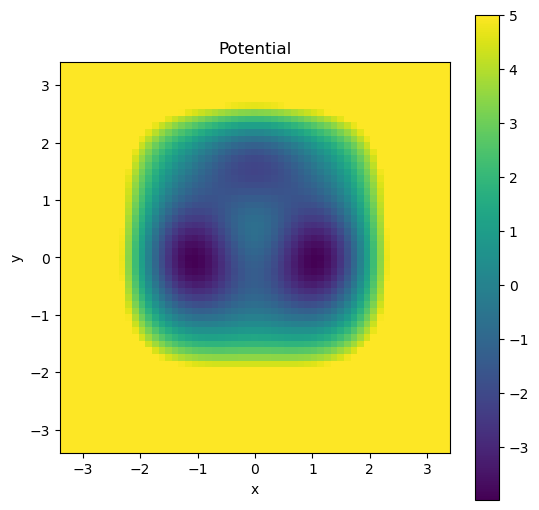

In [2]:
# Potential energy function
def V(x, y):
    #return (x**2 - 1)**2 + 0.5*y * x + y**2     # kJ mol-1
    return 3 * np.exp(-x ** 2 - (y - 1/3) ** 2) \
    - 3 * np.exp(-x ** 2 - (y - 5/3) ** 2) \
    - 5 * np.exp(-(x - 1) ** 2 - y ** 2) \
    - 5 * np.exp(-(x + 1) ** 2 - y ** 2) \
    + 0.2 * x ** 4 \
    + 0.2 * (y - 1/3) ** 4

# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
mass  = 1           # amu
gamma = 1           # ps-1

D     = kB * T / mass / gamma # nm2 ps-1
sigma = np.sqrt(2 * D)
beta  = 1 / kB / T

# Grid
nd     =  2  # Number of dimensions
xbins  = 60  # x boundaries
xmin   = -3.4
xmax   =  3.4

ybins  = 60  # y boundaries
ymin   = -3.4
ymax   =  3.4


xedges = np.linspace(xmin, xmax, xbins)  # array with x edges
dx     = xedges[1] - xedges[0]
x      = xedges[:-1] + (dx / 2)                # array with x centers
xbins  = xbins - 1

yedges = np.linspace(ymin, ymax, ybins)  # array with y edges
dy     = yedges[1] - yedges[0]
y      = yedges[:-1] + (dy / 2)                # array with y centers
ybins  = ybins - 1

Nbins  = xbins*ybins                      # number of bins

grid = np.meshgrid(x,y)


fig, ax1 = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

pos = ax1.pcolor(grid[0], grid[1], V(grid[0], grid[1]), shading='auto', vmax=5)
ax1.set_title('Potential')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(pos, ax=ax1)

## Create Voronoi tessellation

In [3]:
# Number of initial points uniformly distributed
Npoints  = 10000
xpoints  = np.random.uniform(xmin, xmax, Npoints)
ypoints  = np.random.uniform(ymin, ymax, Npoints)
points   = np.array((xpoints, ypoints))

# Number of cluster cells
Ncells  = 100

cells = kmeans(points.T,Ncells,iter=50)
cells = cells[0]
cc_x = cells[:,0]
cc_y = cells[:,1]

vor = clippedVoronoi.voronoi(cells, (xmin, xmax, ymin, ymax))

xcenters = vor.filtered_points[:,0]
ycenters = vor.filtered_points[:,1]

############################# R E G U L A R   G R I D #################

# Grid
xbins  = int(np.sqrt(Ncells))
ybins  = int(np.sqrt(Ncells))

xedges = np.linspace(xmin, xmax, xbins + 1)  # array with x edges
dx     = xedges[1] - xedges[0]
x      = xedges[:-1] + (dx / 2)                # array with x centers
xbins  = xbins - 1

yedges = np.linspace(ymin, ymax, ybins + 1)  # array with y edges
dy     = yedges[1] - yedges[0]
y      = yedges[:-1] + (dy / 2)                # array with y centers
ybins  = ybins - 1

Nbins  = xbins*ybins                      # number of bins

grid = np.meshgrid(x,y)

# Grid contains 2 matrices xbins x ybins with the x and y coordinates
# This transforms the two matrices in two vectors (x,y)

cells_grid = np.array([grid[0].flatten('F'), grid[1].flatten('F')]).T
vor_grid = clippedVoronoi.voronoi(cells_grid, (xmin, xmax, ymin, ymax))

xcenters_grid = vor_grid.filtered_points[:,0]
ycenters_grid = vor_grid.filtered_points[:,1]

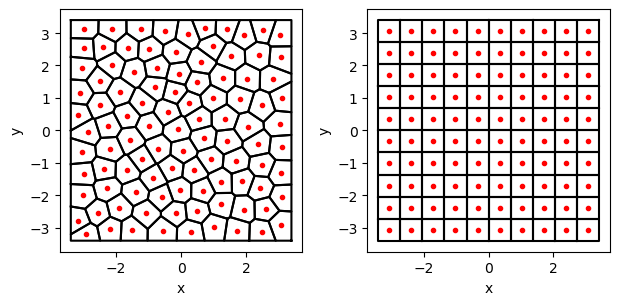

In [4]:
############################# F I G U R E  #################

fig, (ax0, ax1) = plt.subplots(1, 2,figsize=(16*in2cm, 16*in2cm))  


for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    ax0.plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax0.plot(xcenters[i], ycenters[i], 'ro', markersize=3)
ax0.set_aspect('equal', 'box')

ax0.set_xlabel('x')
ax0.set_ylabel('y')



for i,region in enumerate(vor_grid.filtered_regions):
    vertices = vor_grid.vertices[region + [region[0]], :]
    ax1.plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax1.plot(xcenters_grid[i], ycenters_grid[i], 'ro', markersize=3)
ax1.set_aspect('equal', 'box')

ax1.set_xlabel('x')
ax1.set_ylabel('y')

fig.tight_layout()

## Adjaceny matrix

Adjacency matrix is generated searching Voronoi cells sharing the same vertices.
The same script is using to estimate the matrix $\mathcal{S}_{ij}$ with the intersecting surfaces and the matrix $h_{ij}$ distance between adjacent points.

In [5]:
# Volumes    
Vol      = np.zeros(Ncells)

# Adjacency matrix
A      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Intersecting areas
S      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Distances between neighboring points 
h      = scipy.sparse.lil_matrix((Ncells, Ncells))

# Note that len(vor.filtered_regions) = Ncells
# region = Voronoi cell
for i,region in enumerate(vor.filtered_regions):
    
    vertices = vor.vertices[region + [region[0]], :]
    Vol[i] = ConvexHull(vertices).volume

    for j in range(i+1, Ncells):
        
        #ri and rj contain the indeces of the vertices of the region omega_i and omega_j
        ri = vor.filtered_regions[i]
        rj = vor.filtered_regions[j]
        int_sur = np.intersect1d(ri, rj)

        # if two cells share vertices, 
        if int_sur.size != 0:
            
            # then they are adjacent:
            A[i,j] = 1
            A[j,i] = 1
            
            # Coordinates of the cells centers
            v0_x       = vor.filtered_points[i,0]
            v0_y       = vor.filtered_points[i,1]
            v1_x       = vor.filtered_points[j,0]
            v1_y       = vor.filtered_points[j,1]
            
            # Distance between the centers
            distance = np.sqrt( (v1_x - v0_x)**2 + (v1_y - v0_y)**2 )
            h[i,j]   = distance
            h[j,i]   = distance
            
            # Coordinates of the intersecting vertices
            int_sur0_x = vor.vertices[int_sur[0],0]
            int_sur0_y = vor.vertices[int_sur[0],1]
            int_sur1_x = vor.vertices[int_sur[1],0]
            int_sur1_y = vor.vertices[int_sur[1],1]
                        
            # Intersecting area (length of the common edge)
            area = np.sqrt( (int_sur1_x - int_sur0_x)**2 + (int_sur1_y - int_sur0_y)**2 )
            S[i,j] = area
            S[j,i] = area
            
# Adjancency matrix for grids
A_grid = adjacency_matrix_grid(int(np.sqrt(Ncells)), 2, periodic=False)

## SqRA

$$
\pi(x,y) = \exp(-\beta V(x,y))
$$

$$
Q_{ij} = D \frac{\mathcal{S}_{ij}}{\mathcal{V}_i h_{ij}} \sqrt{\frac{\pi_j}{\pi_i}}
$$

In [6]:
# Boltzmann distribution
pi   = np.exp(-beta * V(cc_x, cc_y))
sqra = np.sqrt(pi)

Q = scipy.sparse.lil_matrix((Ncells, Ncells))

for i in range(Ncells):
    for j in range(Ncells):
        if A[i,j] == 1:
            Q[i,j] = D * S[i,j] / Vol[i] / h[i,j] * sqra[j] / sqra[i]
            
# The diagonal is equal to minus the row-sum
Q    = Q + scipy.sparse.spdiags( - Q.sum(axis=1).T, 0, Ncells, Ncells)
 
    
# Boltzmann distribution
pi_grid   = np.exp(-beta * V(cells_grid[:,0], cells_grid[:,1]))
sqra_grid = np.sqrt(pi_grid)

Q_grid = scipy.sparse.lil_matrix((Ncells, Ncells))

for i in range(Ncells):
    for j in range(Ncells):
        if A_grid[i,j] == 1:
            Q_grid[i,j] = D * 1/dx**2 * sqra_grid[j] / sqra_grid[i]
            
# The diagonal is equal to minus the row-sum
Q_grid    = Q_grid + scipy.sparse.spdiags( - Q_grid.sum(axis=1).T, 0, Ncells, Ncells)
 

Text(0.5, 1.0, 'Q with regular grid')

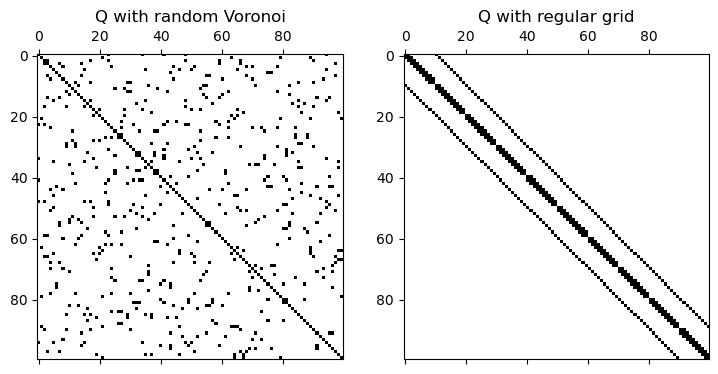

In [7]:
# Q is a sparse matrix
fig, (ax0, ax1) = plt.subplots(1, 2,figsize=(22*in2cm, 22*in2cm))  

ax0.spy(Q.toarray())
ax0.set_title('Q with random Voronoi')
ax1.spy(Q_grid.toarray())
ax1.set_title('Q with regular grid')


## Eigenvalue problem
Estimate left eigenvectors and eigenvalues:

$$
Q \varphi_i(x) = \lambda_i \varphi_i(x)
$$

In [8]:
# Number of eigenvectors
Nevecs = 50

# Eigenvalue problem
evals, evecs = scipy.sparse.linalg.eigs(Q.T, Nevecs, which='LR')
evals = np.real(evals)
evecs = np.real(evecs)
evecs[:,0] = np.abs(evecs[:,0])

e0 = np.real(evecs[:,0])
e1 = np.real(evecs[:,1])
e2 = np.real(evecs[:,2])

# Eigenvalue problem
evals_grid, evecs_grid = scipy.sparse.linalg.eigs(Q_grid.T, Nevecs, which='LR')
evals_grid = np.real(evals_grid)
evecs_grid = np.real(evecs_grid)
evecs_grid[:,0] = np.abs(evecs_grid[:,0])

e0_grid = np.real(evecs_grid[:,0])
e1_grid = np.real(evecs_grid[:,1])
e2_grid = np.real(evecs_grid[:,2])

Text(0.5, 1.0, 'Eigenvalues')

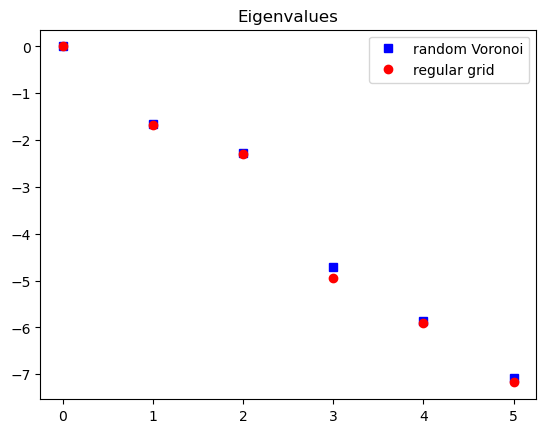

In [9]:
plt.plot(evals[0:6],'bs', label = 'random Voronoi')
plt.plot(evals_grid[0:6],'ro', label = 'regular grid')
plt.legend()
plt.title('Eigenvalues')

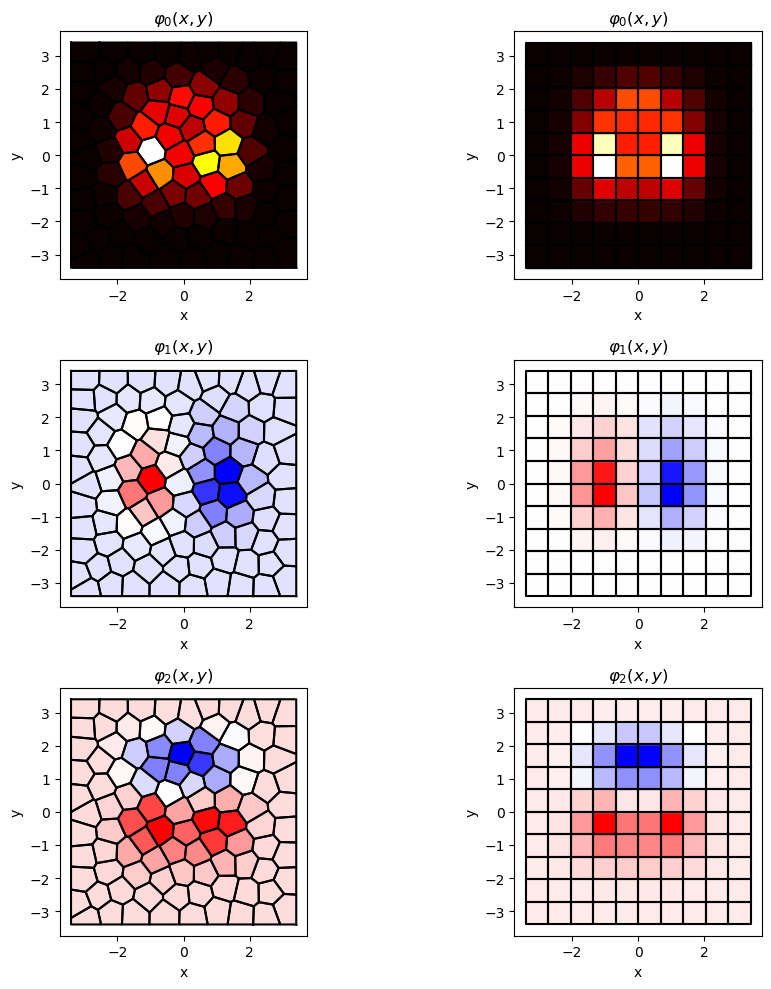

In [11]:
#
# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)


fig, (ax) = plt.subplots(3, 2, figsize=(10,10))


# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0), vmax=np.max(e0), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[0,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[0,0].fill(*zip(*polygon), color=mapper.to_rgba(e0[i]));
    ax[0,0].set_aspect('equal', 'box')
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('y')
    ax[0,0].set_title(r'$\varphi_0(x,y)$')
    
    
    
norm = mpl.colors.Normalize(vmin=np.min(e1), vmax=np.max(e1), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[1,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[1,0].fill(*zip(*polygon), color=mapper.to_rgba(e1[i]));
    ax[1,0].set_aspect('equal', 'box')
    ax[1,0].set_xlabel('x')
    ax[1,0].set_ylabel('y')
    ax[1,0].set_title(r'$\varphi_1(x,y)$')
    
    
norm = mpl.colors.Normalize(vmin=np.min(e2), vmax=np.max(e2), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor.filtered_regions):
    vertices = vor.vertices[region + [region[0]], :]
    polygon = [vor.vertices[j] for j in region]
    ax[2,0].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[2,0].fill(*zip(*polygon), color=mapper.to_rgba(e2[i]));
    ax[2,0].set_aspect('equal', 'box')
    ax[2,0].set_xlabel('x')
    ax[2,0].set_ylabel('y')
    ax[2,0].set_title(r'$\varphi_2(x,y)$')
    
    
################################ R E G U L A R   G R I D ########################################

# normalize chosen colormap
norm = mpl.colors.Normalize(vmin=np.min(e0_grid), vmax=np.max(e0_grid), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.hot)

for i,region in enumerate(vor_grid.filtered_regions):
    vertices = vor_grid.vertices[region + [region[0]], :]
    polygon = [vor_grid.vertices[j] for j in region]
    ax[0,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[0,1].fill(*zip(*polygon), color=mapper.to_rgba(e0_grid[i]));
    ax[0,1].set_aspect('equal', 'box')
    ax[0,1].set_xlabel('x')
    ax[0,1].set_ylabel('y')
    ax[0,1].set_title(r'$\varphi_0(x,y)$')
    
    
    
norm = mpl.colors.Normalize(vmin=np.min(e1_grid), vmax=np.max(e1_grid), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor_grid.filtered_regions):
    vertices = vor_grid.vertices[region + [region[0]], :]
    polygon = [vor_grid.vertices[j] for j in region]
    ax[1,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[1,1].fill(*zip(*polygon), color=mapper.to_rgba(-e1_grid[i]));
    ax[1,1].set_aspect('equal', 'box')
    ax[1,1].set_xlabel('x')
    ax[1,1].set_ylabel('y')
    ax[1,1].set_title(r'$\varphi_1(x,y)$')
    
    
norm = mpl.colors.Normalize(vmin=np.min(e2_grid), vmax=np.max(e2_grid), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)

for i,region in enumerate(vor_grid.filtered_regions):
    vertices = vor_grid.vertices[region + [region[0]], :]
    polygon = [vor_grid.vertices[j] for j in region]
    ax[2,1].plot(vertices[:, 0], vertices[:, 1], 'k-')
    ax[2,1].fill(*zip(*polygon), color=mapper.to_rgba(e2_grid[i]));
    ax[2,1].set_aspect('equal', 'box')
    ax[2,1].set_xlabel('x')
    ax[2,1].set_ylabel('y')
    ax[2,1].set_title(r'$\varphi_2(x,y)$')
    
    
fig.tight_layout();

In [15]:
from pcca import pcca, schurvects

# Dense matrix
Qd = np.real(Q.toarray())

K         = scipy.linalg.expm( 100*0.001 * Qd )

nc  =  3

chi, e, Spcca, X = pcca(Qd, 3, massmatrix=None)

Qc = np.linalg.pinv(chi).dot(Qd.dot(chi))

print(Qc)

Optimization terminated successfully.
         Current function value: -63.553688
         Iterations: 168
         Function evaluations: 290
[[-2.04220585  1.01868796  1.0235179 ]
 [ 0.24222084 -0.94812694  0.7059061 ]
 [ 0.23762167  0.70210032 -0.93972199]]
